
[Open In Colab](https://colab.research.google.com/github/google/fedjax/blob/main/experimental/notebooks/emnist_p13n.ipynb)

In [ ]:
import fedjax
import jax
from jax import jit
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from typing import NamedTuple

fedjax.training.set_tf_cpu_only()

```
# To disable jit, use 'with jax.disable_jit():'
# For example,
@jax.jit
def f(x):
  print(x)
  return jnp.sum(x)

x = jnp.ones([])

print('jit enabled')
for _ in range(10):
  f(x)

print('jit disabled')
with jax.disable_jit():
  for _ in range(10):
    f(x)
```

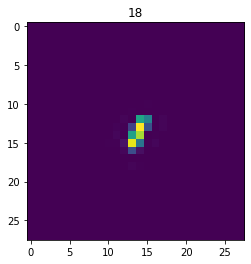

In [ ]:
# Load the model and the data.
model = fedjax.models.emnist.create_conv_model(only_digits=False)
train, test = fedjax.datasets.emnist.load_data(only_digits=False,
                                               cache_dir='/tmp/emnist_data')
# Print a single client data to verify data is loaded.
example_client_id = 'f0000_14'
single_client_data = train.create_tf_dataset_for_client(example_client_id)
numpy_client_data = list(single_client_data.as_numpy_iterator())
pixels = numpy_client_data[0]['x']
label = numpy_client_data[0]['y']
plt.title(f'{label}')
plt.imshow(pixels.reshape(28, 28))

In [ ]:
# Define federated algorithm.

Model = fedjax.Model
Params = fedjax.Params
OptState = fedjax.OptState
Optimizer = fedjax.Optimizer

class FedAvgServerState(NamedTuple):
  params: Params
  opt_state: OptState

class SimpleFedAvg():

  def __init__(self,
               model: Model,
               client_optimizer: Optimizer,
               server_optimizer: Optimizer,
               client_batch_size: int):
    self.model = model
    self.client_optimizer = client_optimizer
    self.server_optimizer = server_optimizer
    self.client_batch_size = client_batch_size
  
  def client_update(self, server_state, client_data):
    params = server_state.params
    opt_state = self.client_optimizer.init_fn(params)
    num_examples = 0.
    rng_seq = fedjax.PRNGSequence(0)
    for batch, rng in zip(client_data, rng_seq):
      backward_pass_output = self.model.backward_pass(params, batch, rng)
      grads = backward_pass_output.grads
      updates, opt_state = self.client_optimizer.update_fn(grads, opt_state)
      params = self.client_optimizer.apply_updates(updates, params)
      num_examples += backward_pass_output.num_examples
    delta = jax.tree_util.tree_multimap(lambda a, b: a - b, 
                                        server_state.params,
                                        params)
    return delta, num_examples

  def server_update(self, server_state, client_outputs):
    weighted_averaged_delta = fedjax.tree_mean(client_outputs)
    updates, opt_state = server_optimizer.update_fn(weighted_averaged_delta,
                                                    server_state.opt_state)
    params = server_optimizer.apply_updates(updates, server_state.params)
    return FedAvgServerState(params, opt_state)

  def init(self, rng):
    params = model.init_params(rng)
    opt_state = self.server_optimizer.init_fn(params)
    return FedAvgServerState(params, opt_state)

  def run_one_round(self, server_state, client_ids):
    client_outputs = []
    for client_id in client_ids:
      client_data = train.create_tf_dataset_for_client(client_id)
      client_data = client_data.batch(self.client_batch_size)
      client_data = client_data.as_numpy_iterator()
      client_outputs.append(self.client_update(server_state, client_data))
    return self.server_update(server_state, client_outputs)

In [ ]:
# Run federated algorithm.
# The hyper-parameters here is not the state of the art. It achieves a
# global test accuracy of 84.6%.
num_rounds = 1000
num_clients_per_round = 10
rng=0
client_batch_size=10
client_optimizer = fedjax.get_optimizer(fedjax.OptimizerName.SGD,
                                        learning_rate=0.1)
server_optimizer = fedjax.get_optimizer(fedjax.OptimizerName.SGD,
                                        learning_rate=1.0)

algorithm = SimpleFedAvg(model, client_optimizer,
                         server_optimizer, client_batch_size)
start = time.time()
server_state = algorithm.init(rng)
np.random.seed(0)
for round_num in range(1, num_rounds + 1):
  client_ids = np.random.choice(train.client_ids, 
                                size=num_clients_per_round,
                                replace=False)
  server_state = algorithm.run_one_round(server_state, client_ids)
  if round_num % 10 == 0:
    print('round_num: {}, mean_round_duration: {} sec'.format(
        round_num, (time.time() - start)/10))
    start = time.time() 
global_params = server_state.params

round_num: 10, mean_round_duration: 2.4179877758026125 sec
round_num: 20, mean_round_duration: 1.2856221437454223 sec
round_num: 30, mean_round_duration: 1.2583433389663696 sec
round_num: 40, mean_round_duration: 1.293632435798645 sec
round_num: 50, mean_round_duration: 1.3177392482757568 sec
round_num: 60, mean_round_duration: 1.2409819602966308 sec
round_num: 70, mean_round_duration: 1.4055363655090332 sec
round_num: 80, mean_round_duration: 1.324507236480713 sec
round_num: 90, mean_round_duration: 1.3277878999710082 sec
round_num: 100, mean_round_duration: 1.2576950073242188 sec
round_num: 110, mean_round_duration: 1.265484356880188 sec
round_num: 120, mean_round_duration: 1.3302254915237426 sec
round_num: 130, mean_round_duration: 1.3305392742156983 sec
round_num: 140, mean_round_duration: 1.2630117654800415 sec
round_num: 150, mean_round_duration: 1.2149299144744874 sec
round_num: 160, mean_round_duration: 1.317898726463318 sec
round_num: 170, mean_round_duration: 1.24967248439788

In [ ]:
# Evaluate the global model
hparams = fedjax.ClientDataHParams(batch_size=10, num_epochs=1) 
all_metrics = fedjax.evaluate_multiple_clients(federated_data=test, 
                                               client_ids=test.client_ids,
                                               model=model,
                                               params=global_params,
                                               client_data_hparams=hparams)
all_metrics = list(all_metrics)
print(pd.DataFrame.from_records(all_metrics).mean())


loss             0.448871
regularizer      0.000000
num_examples    22.789118
accuracy         0.846229
dtype: float64


In [ ]:
# Finetune the model and evaluate before and after finetuning.
# The hyper-parameters here is not the state of the art. It achieves a
# finetune test accuracy of 84.6%.

finetune_batch_size=10
client_optimizer = fedjax.get_optimizer(fedjax.OptimizerName.SGD,
                                        learning_rate=0.1)
global_metrics = {}
finetune_metrics = {}
start = time.time()
num_clients = 3400
for client_id in train.client_ids[0:num_clients]:
  # Finetune algorithm.
  params = global_params
  client_train_data = train.create_tf_dataset_for_client(
      client_id).batch(finetune_batch_size).as_numpy_iterator()
  rng_seq = fedjax.PRNGSequence(0)
  opt_state = client_optimizer.init_fn(params)
  for batch, rng in zip(client_train_data, rng_seq):
      backward_pass_output = model.backward_pass(params, batch, rng)
      grads = backward_pass_output.grads
      updates, opt_state = client_optimizer.update_fn(grads, opt_state)
      params = client_optimizer.apply_updates(updates, params)

  # train and test evaluations.
  client_test_tf_data = test.create_tf_dataset_for_client(client_id)
  global_metrics[client_id] = fedjax.evaluate_single_client(
      client_test_tf_data.batch(16), model, global_params)
  finetune_metrics[client_id] = fedjax.evaluate_single_client(
      client_test_tf_data.batch(16), model, params)

print('mean_personalization_duration: {} sec.'.format(
    (time.time() - start)/num_clients))


mean_personalization_duration: 0.17590635152424083 sec.


Global metrics loss             0.448871
regularizer      0.000000
num_examples    22.789118
accuracy         0.846229
dtype: float64
Finetune metrics loss             0.374029
regularizer      0.000000
num_examples    22.789118
accuracy         0.878630
dtype: float64


Text(0, 0.5, 'finetune_accuracy')

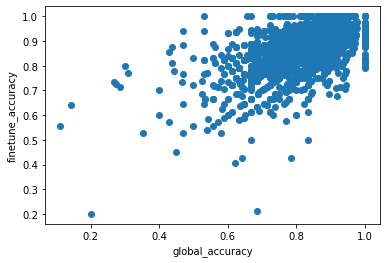

In [ ]:
# Compute aggregate metrics and plot accuracies.
print("Global metrics", pd.DataFrame.from_records(
    list(global_metrics.values())).mean())
print("Finetune metrics", pd.DataFrame.from_records(list(
    finetune_metrics.values())).mean())

global_accuracy = [metric['accuracy'] 
                   for metric in list(global_metrics.values())]
finetune_accuracy = [metric['accuracy'] 
                     for metric in list(finetune_metrics.values())]
plt.scatter(global_accuracy, finetune_accuracy)
plt.xlabel('global_accuracy')
plt.ylabel('finetune_accuracy')